In [1]:
%load_ext autoreload
%autoreload 2

import os
import xarray as xr
import dask
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from aurora_benchmark.utils import xr_to_netcdf, update_running_statistics, reduce_statistics

dask.config.set(scheduler='threads')

In [2]:
p = "../toy_data/era5-1d-360x180/msl-2021-2022-1d-360x180.nc"
surf_vars = ["2t", "msl", "10u"]
atmospheric_vars = ["t", "q", "u"]
static_vars = ["z", "lsm", "slt"]

In [3]:
# Function arguments
toy = True
print(f"TOY: {toy}")

if toy:
    era5_surface_paths = [
        p, p, p
    ]
    era5_atmospheric_paths = [
        p, p, p
    ]
    era5_static_paths = [
        p, p, p
    ]

    interest_variables = atmospheric_vars + surf_vars
    interest_levels = [1000, 700, 250]

    forecast_dir = "data/era5_wb2_forecasts/2021-2022-6h-1d-6w-1440x721_original_variables/"
    eval_dir = "data/era5_wb2_eval/2021-2022-6h-1d-6w-1440x721_original_variables"
    
    # Load the data into a single dataset with the same coords but multiple variables
    surface_ds = xr.merge([
        xr.open_dataset(path, engine="netcdf4")\
            .rename({"msl": svar})\
            .drop_vars("time_bnds")
        for path, svar in zip(era5_surface_paths, surf_vars)
    ])

    atmospheric_ds = xr.merge([
        xr.open_dataset(path, engine="netcdf4") \
            .rename({"msl": svar}) \
            .expand_dims({"level": interest_levels}) \
            .drop_vars("time_bnds")
        for path, svar in zip(era5_atmospheric_paths, atmospheric_vars)
    ])

    static_ds = xr.merge([
        xr.open_dataset(path, engine="netcdf4").rename({"msl": svar}).isel(time=0).drop_vars("time_bnds")
        for path, svar in zip(era5_atmospheric_paths, atmospheric_vars)
    ])

    # rename coord lat to latitude and lon to longitude
    surface_ds = surface_ds.rename({"lat": "latitude", "lon": "longitude"})
    atmospheric_ds = atmospheric_ds.rename({"lat": "latitude", "lon": "longitude"})
    static_ds = static_ds.rename({"lat": "latitude", "lon": "longitude"})
   
else: 
    era5_surface_paths = [
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/10v_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/2t_2021-2022-6h-1440x721.nc",
    #  - data/era5_wb2/2021-2022-6h-1440x721/tp_2021-2022-6h-1440x721.nc # original only
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/10u_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/msl_2021-2022-6h-1440x721.nc",
    #  - data/era5_wb2/2021-2022-6h-1440x721/sst_2021-2022-6h-1440x721.nc # original only
    ]
    era5_atmospheric_paths = [
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/q_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/t_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/u_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/v_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/z_2021-2022-6h-1440x721.nc",
    ]
    era5_static_paths = [
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/lsm_static-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/z_static-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/slt_static-1440x721.nc",
    ]

    interest_variables = atmospheric_vars + surf_vars
    interest_levels = [1000, 700, 250]

    forecast_dir = "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2_forecasts/2021-2022-6h-1d-6w-1440x721_original_variables/"
    eval_dir = "data/era5_wb2_eval/2021-2022-6h-1d-6w-1440x721_original_variables"
    
    # Load the data into a single dataset with the same coords but multiple variables
    surface_ds = xr.merge([
        xr.open_dataset(p, engine="netcdf4", chunks={"time": 50, "latitude": 721, "longitude": 1440})
        for p in era5_surface_paths
    ])

    atmospheric_ds = xr.merge([
        xr.open_dataset(p, engine="netcdf4", chunks={"time": 50, "latitude": 721, "longitude": 1440, "level": 1})
        for p in era5_atmospheric_paths
    ])

    static_ds = xr.merge([
        xr.open_dataset(p, engine="netcdf4", chunks={"latitude": 721, "longitude": 1440})
        for p in era5_static_paths
    ])


assert os.path.exists(forecast_dir), f"Forecast directory {forecast_dir} does not exist"
os.makedirs(eval_dir, exist_ok=True)

surface_ds.dims, atmospheric_ds.dims, static_ds.dims

TOY: True


(FrozenMappingWarningOnValuesAccess({'time': 365, 'longitude': 360, 'latitude': 180}),
 FrozenMappingWarningOnValuesAccess({'level': 3, 'time': 365, 'longitude': 360, 'latitude': 180}),
 FrozenMappingWarningOnValuesAccess({'longitude': 360, 'latitude': 180}))

In [39]:
import xarray as xr

class RunningStatistics(object):
    def __init__(self):
        self._means = {}
        self.means_of_squared = {}
        self.num_samples = {}

    def update(self, sample_ds: xr.Dataset):
        for var in sample_ds.data_vars:
            if var not in self.num_samples:
                print(f"New variable {var}")
                self.num_samples[var] = 0
                self._means[var] = sample_ds[var]
                self.means_of_squared[var] = sample_ds[var]**2
                print(f"means[var] shape:", self._means[var].shape)
                print(f"means_of_squared[var] shape:", self.means_of_squared[var].shape)
            else:
                print(f"Accumulating variable {var}")
                self._means[var] = (self._means[var] * self.num_samples[var] + sample_ds[var]) / (self.num_samples[var] + 1)
                self.means_of_squared[var] = (self.means_of_squared[var] * self.num_samples[var] + sample_ds[var]**2) / (self.num_samples[var] + 1)
                print(f"means[var] shape:", self._means[var].shape)
                print(f"means_of_squared[var] shape:", self.means_of_squared[var].shape)
            self.num_samples[var] += 1

    @property
    def stds(self):
        return xr.Dataset({var: (self.means_of_squared[var] - self._means[var]**2)**0.5 for var in self._means})
    
    @property
    def means(self):
        return xr.Dataset(self._means)
    
    def rmse(self, dim=["latitude", "longitude"]):
        return np.sqrt(((self.means**2).mean(dim=dim)))
    
    @property
    def variables(self):
        return list(self.num_samples.keys())

In [40]:
running_statistics = {
    "surface_vars": RunningStatistics(),
    "atmospheric_vars": RunningStatistics(),
}

# loop over files
for i, file in enumerate(os.scandir(forecast_dir)):
    # parse file info
    file_info = file.name.replace(".nc", "").split("_")
    variable_name = file_info[1]
    file_info = file_info[2].split("-")
    init_time = pd.Timestamp(file_info[0])
    base_frequency = file_info[1]
    eval_aggregation = file_info[2]
    eval_start = file_info[3]
    forecast_horizon = file_info[4]    

    # feedback
    print(f"Processing {file.name}")

    # load forecast
    pred_trajectory = xr.open_dataset(file.path, engine="netcdf4")
    assert pd.Timedelta((pred_trajectory.lead_time[1]-pred_trajectory.lead_time[0]).values) == pd.Timedelta(eval_aggregation)

    # load ERA5 gt from surface_ds and atmospheric_ds
    true_ds = atmospheric_ds if variable_name in atmospheric_ds.data_vars else surface_ds
    true_trajectory = true_ds[variable_name]\
            .sel(time=slice(init_time+pd.Timedelta(eval_start), init_time+pd.Timedelta(forecast_horizon)))

    # resample gt to eval_aggregation
    true_trajectory = true_trajectory.resample(time=pd.Timedelta(eval_aggregation), origin=init_time).mean()
    assert pd.Timedelta((true_trajectory.time[1]-true_trajectory.time[0]).values) == pd.Timedelta(eval_aggregation)
    
    # rename true time to lead time
    true_trajectory = true_trajectory.rename({"time": "lead_time"})
    true_trajectory["lead_time"] = true_trajectory["lead_time"] - np.datetime64(init_time)

    # shape
    sizes = pred_trajectory.sizes
    nlt = len(np.unique(pred_trajectory.lead_time.values))
    if variable_name in atmospheric_ds.data_vars:
        stat_key = "atmospheric_vars"
    else:
        stat_key = "surface_vars"
        
    # compute error
    signed_error_ds = (pred_trajectory - true_trajectory)
    running_statistics[stat_key].update(signed_error_ds)
    
    if i == 50: break

Processing forecast_q_20211010T090000-1d-1w-1w-3w-360x180.nc
New variable q
means[var] shape: (2, 3, 180, 360)
means_of_squared[var] shape: (2, 3, 180, 360)
Processing forecast_t_20211004T090000-1d-1w-1w-3w-360x180.nc
New variable t
means[var] shape: (2, 3, 180, 360)
means_of_squared[var] shape: (2, 3, 180, 360)
Processing forecast_u_20210809T090000-1d-1w-1w-3w-360x180.nc
New variable u
means[var] shape: (2, 3, 180, 360)
means_of_squared[var] shape: (2, 3, 180, 360)
Processing forecast_2t_20210728T090000-1d-1w-1w-3w-360x180.nc
New variable 2t
means[var] shape: (2, 180, 360)
means_of_squared[var] shape: (2, 180, 360)
Processing forecast_msl_20211014T090000-1d-1w-1w-3w-360x180.nc
New variable msl
means[var] shape: (2, 180, 360)
means_of_squared[var] shape: (2, 180, 360)
Processing forecast_u_20210228T090000-1d-1w-1w-3w-360x180.nc
Accumulating variable u
means[var] shape: (2, 3, 180, 360)
means_of_squared[var] shape: (2, 3, 180, 360)
Processing forecast_u_20210401T090000-1d-1w-1w-3w-360x1

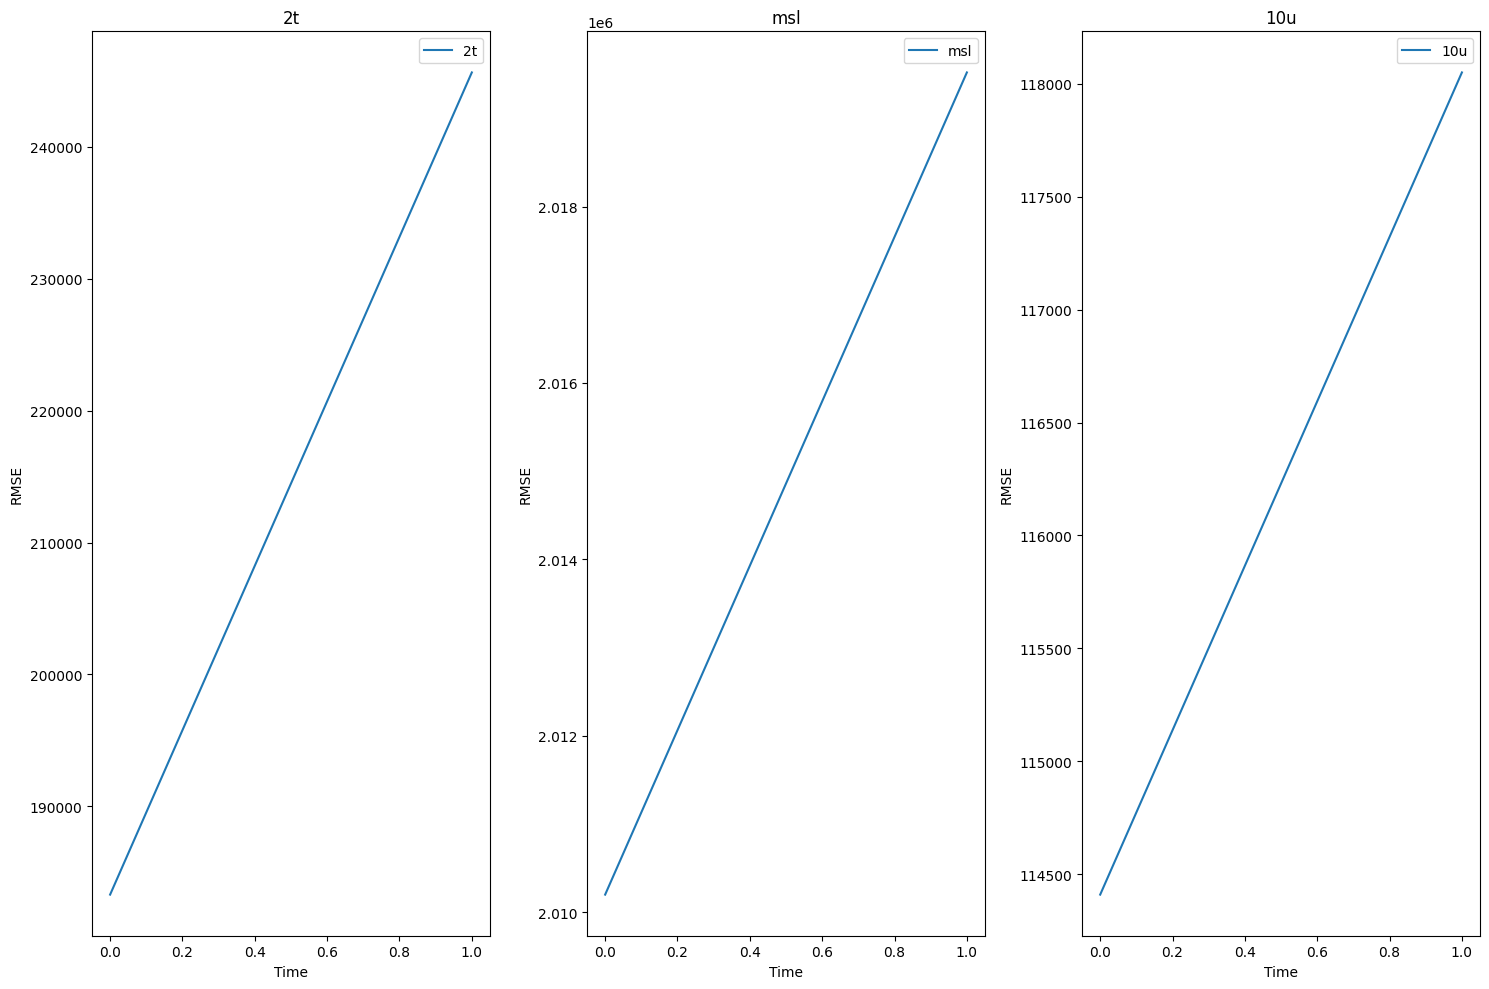

In [43]:
# plot maps

stats = running_statistics["surface_vars"]

num_lead_times = 2

lon_min, lon_max = -8, 38
lat_min, lat_max = 29, 47

fig_curves, axes_curves = plt.subplots(
    ncols=len(stats.variables), 
    figsize=(15, 10)
)

for i, var in enumerate(stats.variables):
    lead_times = [pd.Timedelta(lt) for lt in stats.means[var].lead_time.values]
    ax = axes_curves[i]
    ax.plot(
        stats.rmse(dim=["latitude", "longitude"])[var],
        label=var
    )
    ax.set_title(f"{var}")
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("RMSE")
    ax.grid(False)
plt.tight_layout()
plt.show()
